# Train a VAE on Cell Painting LINCS Data

In [3]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf
import umap



In [2]:
# %load_ext nb_black

In [3]:
# np.random.seed(123)
# python_random.seed(123)
# tf.random.set_random_seed(1234)

In [4]:
data_splits = ["train", "test", "valid", "complete"]
data_dict = load_data(data_splits)

In [5]:
# Prepare data for training
meta_features = infer_cp_features(data_dict["train"], metadata=True)
cp_features = infer_cp_features(data_dict["train"])

train_features_df = data_dict["train"].reindex(cp_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(cp_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(cp_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")


In [6]:
print(train_features_df.shape)
train_features_df.head(3)

(8294, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.56071,0.63708,0.57961,0.51030,0.61695,0.30869,0.43981,0.79826,0.72477,0.68589,...,0.17858,0.29336,0.26447,0.30197,0.64786,0.49525,0.53512,0.40495,0.46056,0.43647
1,0.59702,0.55453,0.62561,0.47959,0.59022,0.33269,0.49875,0.88042,0.67159,0.61703,...,0.09030,0.15088,0.13334,0.14052,0.59229,0.49294,0.43221,0.33969,0.39208,0.36205
2,0.64623,0.59825,0.62822,0.52100,0.57452,0.26367,0.48172,0.86322,0.67588,0.69732,...,0.18125,0.23244,0.20723,0.24062,0.54642,0.43920,0.41183,0.30375,0.35385,0.33266


In [7]:
print(test_features_df.shape)
test_features_df.head(3)

(1037, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.52664,0.59293,0.51636,0.52824,0.54415,0.23948,0.53361,0.84625,0.65881,0.86971,...,0.74413,0.58353,0.54654,0.63600,0.50501,0.39338,0.46080,0.25924,0.29724,0.27556
1,0.61343,0.57882,0.62454,0.51049,0.57508,0.31691,0.49077,0.89145,0.65811,0.66082,...,0.12499,0.20488,0.18676,0.20580,0.58773,0.47783,0.42619,0.34683,0.39642,0.37092
2,0.55123,0.61050,0.53085,0.65280,0.54356,0.16767,0.50521,0.93703,0.77958,0.63413,...,0.19249,0.13665,0.13293,0.13816,0.58333,0.52931,0.31068,0.40967,0.48646,0.45058


In [8]:
print(complete_features_df.shape)
complete_features_df.head(3)

(10368, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.57016,0.59500,0.57370,0.50690,0.56160,0.27321,0.45448,0.83747,0.68635,0.68973,...,0.16426,0.22701,0.20854,0.22897,0.53738,0.43547,0.41635,0.28933,0.34017,0.31368
1,0.54840,0.53949,0.58096,0.53694,0.55009,0.28114,0.53594,0.86929,0.66026,0.71317,...,0.18411,0.23932,0.21854,0.24763,0.56995,0.47084,0.37764,0.32148,0.36964,0.34328
2,0.56057,0.59621,0.59116,0.50418,0.55679,0.29305,0.49221,0.87813,0.71747,0.72229,...,0.17564,0.23366,0.21743,0.23448,0.56980,0.47254,0.39575,0.31969,0.36626,0.34086


In [9]:
# VAE of one layer
encoder_architecture = [250]
decoder_architecture = [250]



In [118]:
# model from optimal hyperparameters for onelayer obtained from 1.optimize
cp_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=10,
    batch_size=96,
    encoder_batch_norm=True,
    epochs=100,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=.3,
    verbose=True,
)
cp_vae.compile_vae()

In [119]:
cp_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/100
87/87 [==============================] - 2s 7ms/step - loss: 65.5144 - val_loss: 28.9976
Epoch 2/100
87/87 [==============================] - 0s 5ms/step - loss: 8.4686 - val_loss: 8.6890
Epoch 3/100
87/87 [==============================] - 0s 5ms/step - loss: 6.2927 - val_loss: 6.1160
Epoch 4/100
87/87 [==============================] - 0s 5ms/step - loss: 5.1824 - val_loss: 4.7395
Epoch 5/100
87/87 [==============================] - 0s 5ms/step - loss: 4.2287 - val_loss: 4.0942
Epoch 6/100
87/87 [==============================] - 0s 5ms/step - loss: 3.7729 - val_loss: 3.7537
Epoch 7/100
87/87 [==============================] - 0s 5ms/step - loss: 3.6856 - val_loss: 3.4924
Epoch 8/100
87/87 [==============================] - 0s 5ms/step - loss: 3.4729 - val_loss: 3.3316
Epoch 9/100
87/87 [==============================] - 0s 5ms/step - loss: 3.3789 - val_loss: 3.2294
Epoch 10/100
87/87 [==============================] - 0s 5ms/step - loss: 3.3526 - val_loss: 3.1854
Epoch 1

Epoch 83/100
87/87 [==============================] - 0s 5ms/step - loss: 2.4412 - val_loss: 2.3617
Epoch 84/100
87/87 [==============================] - 0s 5ms/step - loss: 2.4565 - val_loss: 2.3055
Epoch 85/100
87/87 [==============================] - 0s 5ms/step - loss: 2.4551 - val_loss: 2.4188
Epoch 86/100
87/87 [==============================] - 0s 5ms/step - loss: 2.4384 - val_loss: 2.3753
Epoch 87/100
87/87 [==============================] - 0s 5ms/step - loss: 2.4362 - val_loss: 2.4228
Epoch 88/100
87/87 [==============================] - 0s 5ms/step - loss: 2.4349 - val_loss: 2.5675
Epoch 89/100
87/87 [==============================] - 0s 5ms/step - loss: 2.4018 - val_loss: 2.3106
Epoch 90/100
87/87 [==============================] - 0s 5ms/step - loss: 2.4202 - val_loss: 2.3694
Epoch 91/100
87/87 [==============================] - 0s 5ms/step - loss: 2.4261 - val_loss: 2.3511
Epoch 92/100
87/87 [==============================] - 0s 5ms/step - loss: 2.3769 - val_loss: 2.3501


In [120]:
cp_vae.vae

In [121]:
# cp_vae.vae.evaluate(test_features_df)

In [122]:
# Save training performance
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

,loss,val_loss
0,30.083614,28.997597
1,7.804605,8.689045
2,6.057419,6.116002
3,4.963554,4.739501
4,4.236126,4.094173
...,...,...
95,2.388418,2.337874
96,2.410622,2.393229
97,2.400201,2.415354
98,2.359050,2.294039


In [123]:
history_df.to_csv('level5_training.csv')

In [124]:
# history_df = pd.read_csv('level5_training.csv')

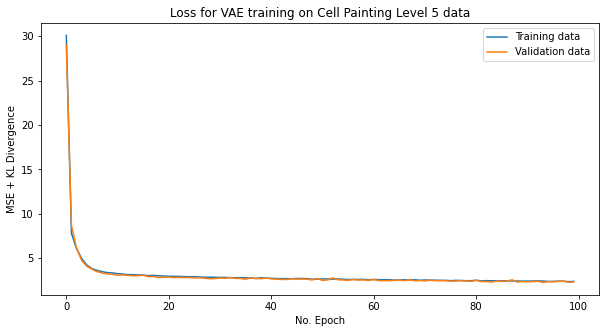

In [125]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on Cell Painting Level 5 data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [126]:
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

40.68704513962693

<AxesSubplot:>

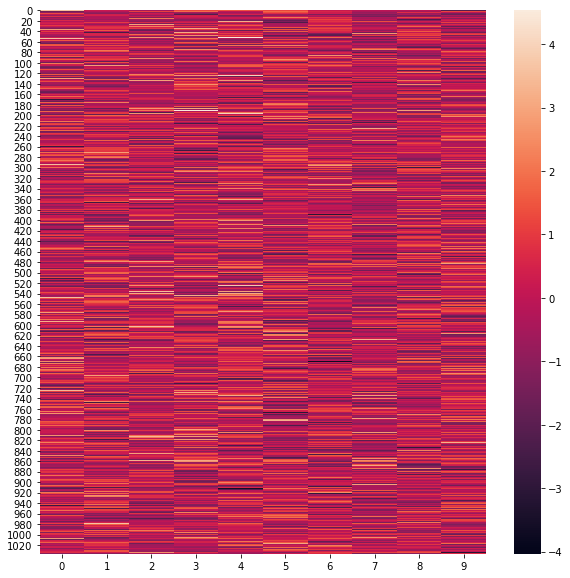

In [127]:
#latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = cp_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

In [63]:
#original vs reconstructed heatmap
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
pca = PCA(n_components=2).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
# seaborn.heatmap(test_features_df, ax=ax1)
# seaborn.heatmap(reconstruction, ax=ax2)
# plt.show()

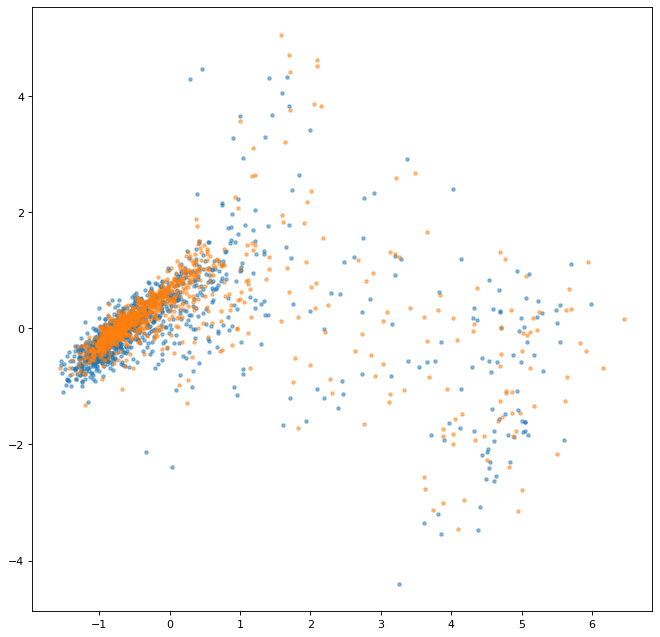

In [65]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[0],pca_reconstructed_latent_df[1], marker = ".", alpha = 0.5)

In [17]:
pca = PCA(n_components=50).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))

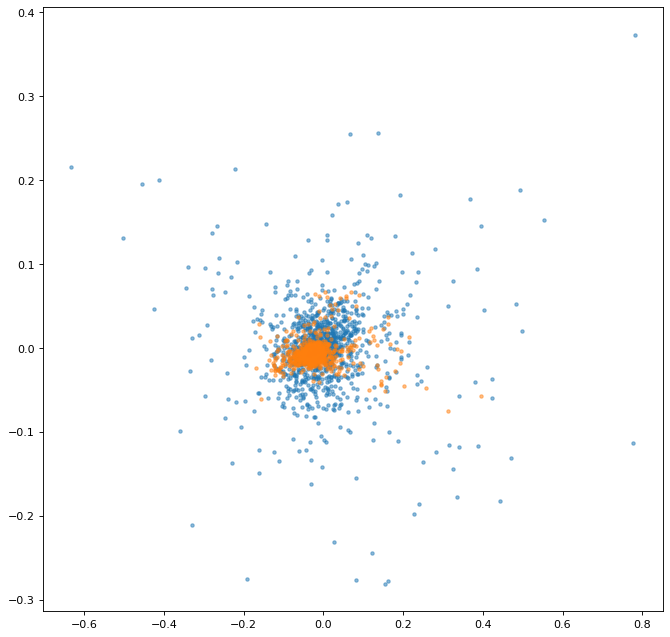

In [24]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[21],pca_test_latent_df[43], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[21],pca_reconstructed_latent_df[43], marker = ".", alpha = 0.5)

In [2]:
decoder = keras.models.load_model("level5Decoder")
encoder = keras.models.load_model("level5Encoder")

In [9]:
reconstruction = decoder.predict(encoder.predict(test_features_df)[2])

In [25]:
import umap
reducer = umap.UMAP().fit(test_features_df)
original_test_embedding = reducer.transform(test_features_df)
reconstructed_test_embedding = reducer.transform(reconstruction)

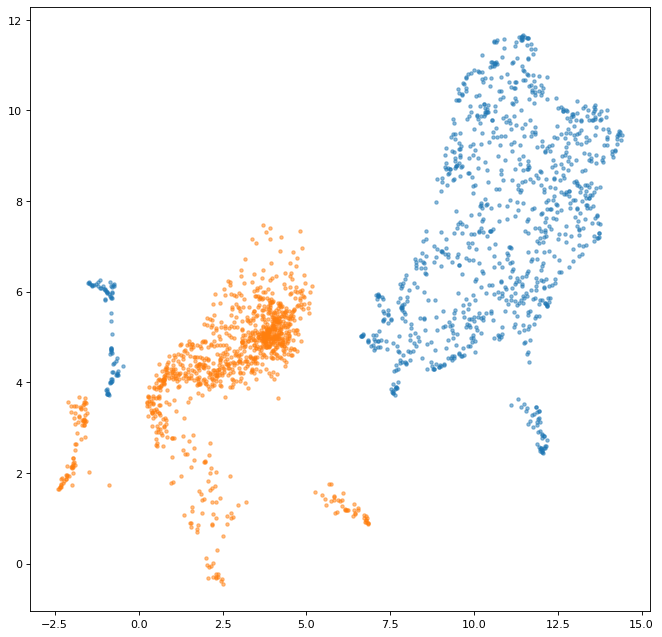

In [30]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(original_test_embedding[:,0],original_test_embedding[:,1], marker = ".", alpha = 0.5)
plt.scatter(reconstructed_test_embedding[:,0],reconstructed_test_embedding[:,1], marker = ".", alpha = 0.5)

<AxesSubplot:>

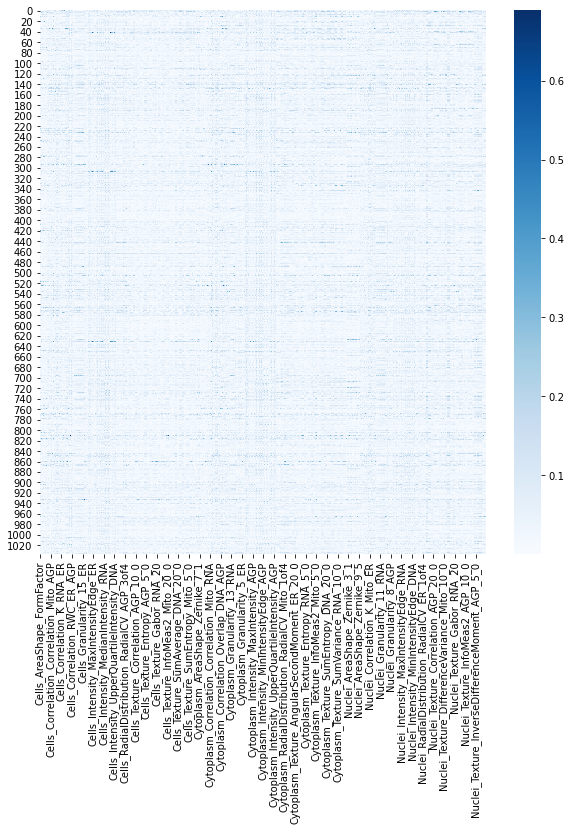

In [130]:
#difference between original and reconstructed heatmap
difference = abs(reconstruction - test_features_df)
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(difference, ax=ax, cmap="Blues")

<AxesSubplot:>

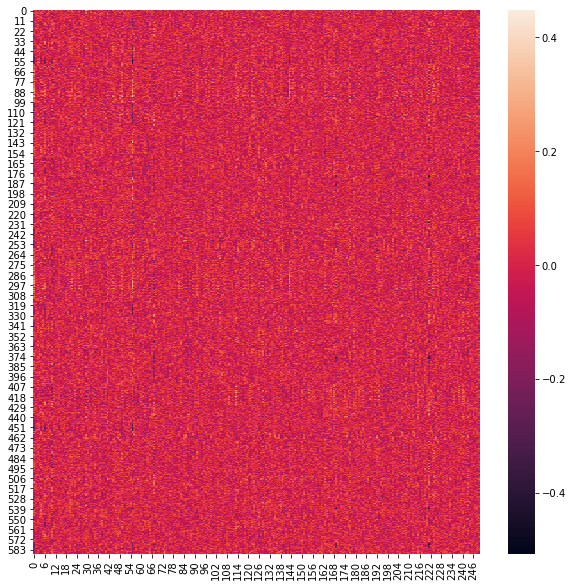

In [131]:
#encoder heatmap
weights = cp_vae.encoder_block["encoder"].get_weights()
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(weights[0], ax=ax)

In [398]:
frobenius_norms = []
for reconstruction in reconstructions:
    frobenius_norms.append(
        (sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5
    )

NameError: name 'reconstructions' is not defined

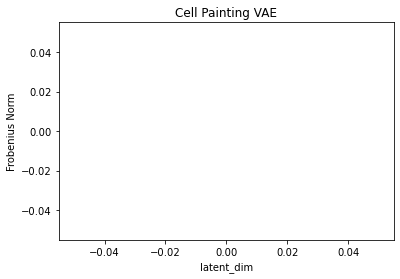

In [399]:
plt.plot(frobenius_norms)
plt.xlabel("latent_dim")
plt.ylabel("Frobenius Norm")
plt.title("Cell Painting VAE")
plt.show()

In [132]:
decoder = cp_vae.decoder_block["decoder"]

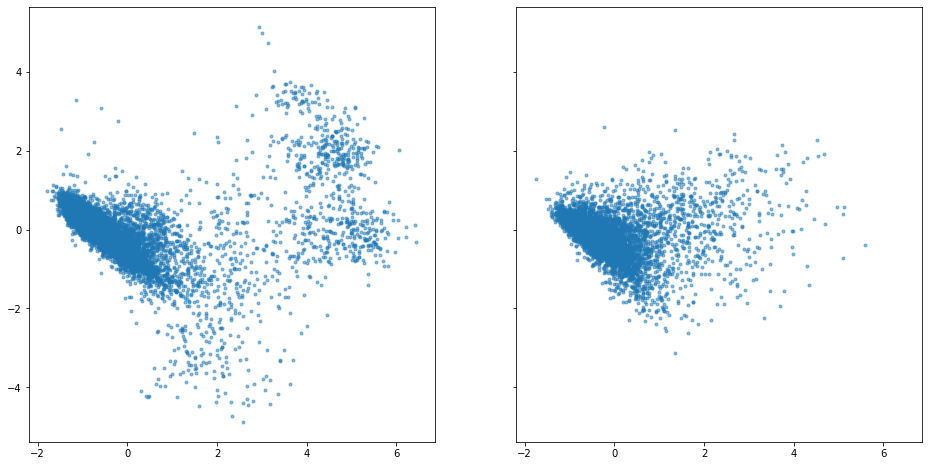

In [27]:

pca_training = PCA(n_components=2).fit(train_features_df)

simulated_df = pd.DataFrame(np.random.normal(size=(8294, 10)), columns=np.arange(0,10))
reconstruction_of_simulated = decoder.predict(simulated_df)
pca_reconstruction_of_simulated = pd.DataFrame(pca_training.transform(reconstruction_of_simulated))
pca_train_latent_df = pd.DataFrame(pca_training.transform(train_features_df))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharey = True, sharex = True)
ax1.scatter(pca_train_latent_df[0],pca_train_latent_df[1], marker = ".", alpha = 0.5)
ax2.scatter(pca_reconstruction_of_simulated[0],pca_reconstruction_of_simulated[1], marker = ".", alpha = 0.5)

In [135]:
from scipy.spatial.distance import directed_hausdorff
max(directed_hausdorff(reconstruction_of_simulated, train_features_df)[0],directed_hausdorff(train_features_df,reconstruction_of_simulated)[0])

5.172733347582099

In [12]:
decoder = keras.models.load_model("level5Decoder")

In [43]:
reducer = umap.UMAP()
original_test_embedding = reducer.fit_transform(test_features_df)

In [33]:
simulated_test_df = pd.DataFrame(np.random.normal(size=(1037, 10)), columns=np.arange(0,10))
reconstruction_of_simulated_test = decoder.predict(simulated_test_df)

In [34]:
simulated_embedding = reducer.transform(reconstruction_of_simulated_test)

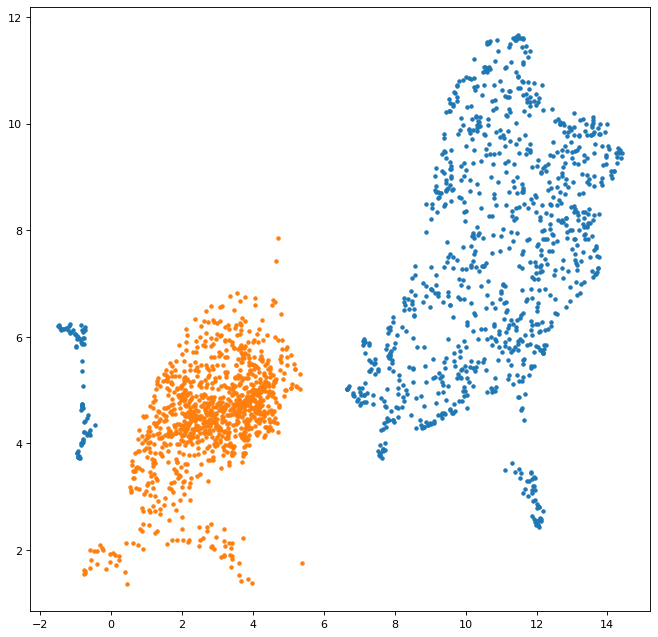

In [35]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(
    original_test_embedding[:, 0],
    original_test_embedding[:, 1],
#     c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})]
    marker = '.'
)
plt.scatter(
    simulated_embedding[:, 0],
    simulated_embedding[:, 1],
#     c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})]
    marker = '.'
)
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the cell painting level 5 test set')

In [136]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent_complete)
latent_df.to_csv("../3.application/level5Latent.csv")

In [13]:
latent_df = pd.read_csv('../3.application/level5Latent.csv').drop('Unnamed: 0', axis=1)

In [ ]:
latent_df

In [14]:
reducer = umap.UMAP()
latent_embedding = reducer.fit_transform(latent_df)

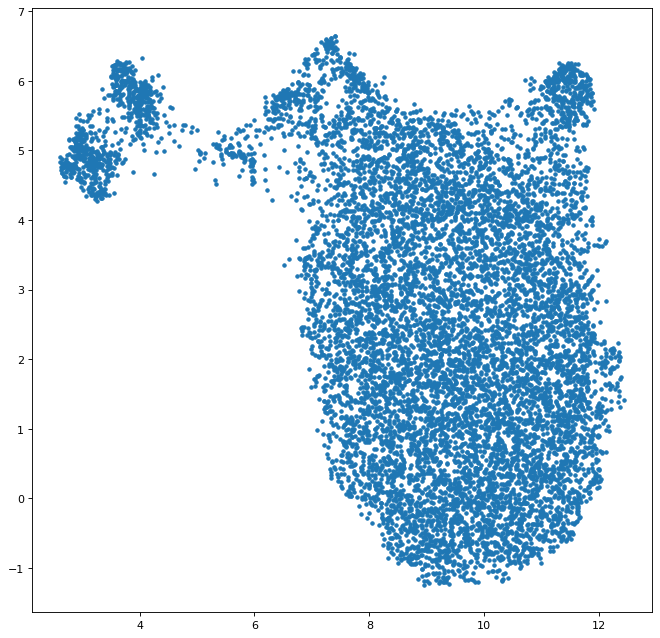

In [15]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(
    latent_embedding[:, 0],
    latent_embedding[:, 1],
    marker = '.'
)

In [137]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder.save("level5Decoder")

INFO:tensorflow:Assets written to: level5Decoder/assets


In [138]:
encoder.save("level5Encoder")

INFO:tensorflow:Assets written to: level5Encoder/assets
